## Kozmos Duygu Durum Analizi

### Kütüphaneler

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('dataset/amazon.xlsx')

In [5]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [6]:
df.tail()

,Star,HelpFul,Title,Review
5606,4,0,Recommend,Great product for reasonable money. Delivered...
5607,5,0,"Terrible , different colors. I returned",Color is way off and panels do not match
5608,5,0,Extremely pleasing,These are great for my studio as they compleme...
5609,5,0,Perfect,Brought out the beauty in kids room. They love...
5610,4,0,Quality Curtains for the price,Very cute curtains in my sons room! Thick enou...


In [7]:
df.shape

(5611, 4)

### 1.)Metin Ön İşleme

In [9]:
# Tüm harfleri küçük harfe çevirelim.
df['Review'] = df['Review'].str.lower()

In [10]:
# Noktalama işaretlerini çıkaralım.
df['Review'] = df['Review'].str.replace(r'[^\w\s]', '', regex=True)

In [11]:
# Sayısal ifadeleri çıkaralım.
df['Review'] = df['Review'].str.replace(r'\d+', '', regex=True)

In [12]:
# Stopwords seçip kaldıralım 
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in sw))

In [13]:
# Rarewords seçip çıkaralım
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()
drops = temp_df[temp_df < 100]

In [14]:
drops

cool            99
looked          98
night           97
hanging         97
theme           96
                ..
neato            1
decormatches     1
thx              1
pricebrid        1
studioliving     1
Name: count, Length: 6570, dtype: int64

In [15]:
temp_df[temp_df > 100]

curtains     1891
love         1312
room         1116
like         1037
beautiful     943
             ... 
block         103
though        103
money         102
order         101
another       101
Name: count, Length: 129, dtype: int64

In [16]:
df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in drops))

In [17]:
# Lemmatization (köklerine ayırma) uygulayalım.
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### 2.)Metin Görselleştirme

#### Terim Frekanslarının Hesaplanması

In [20]:
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

In [21]:
tf.head()

,index,0
0,happy,196.0
1,good,535.0
2,quality,889.0
3,material,561.0
4,panel,226.0


In [22]:
tf.columns = ['words', 'tf']

In [23]:
tf.head()

,words,tf
0,happy,196.0
1,good,535.0
2,quality,889.0
3,material,561.0
4,panel,226.0


#### Barplot

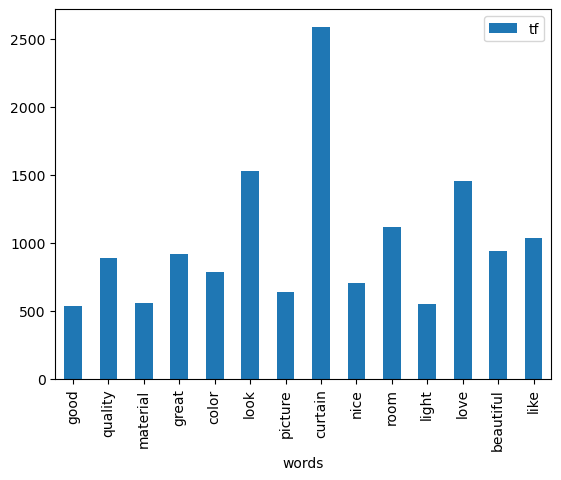

In [25]:
tf[tf['tf'] > 500].plot.bar(x = 'words', y = 'tf')
plt.show()

#### WordCloud

WordCloud ile görselleştirmek için, tüm metni tek bir string'e çevirmeliyiz.

In [28]:
text = ' '.join(x for x in df['Review'])

In [30]:
wordcloud = WordCloud(max_font_size = 50,
                      max_words = 100,
                      background_color = 'white').generate(text)


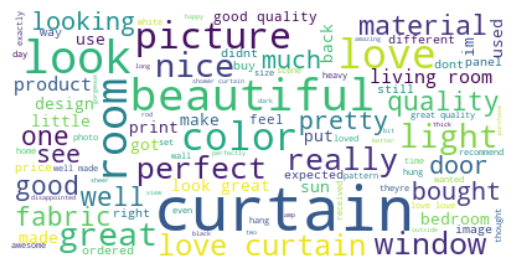

In [31]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 3.)Duygu Durum Analizi

Elimizde olan metinlerin taşıdığı duygu durumunu matematiksel olarak ifade etme yöntemidir.


In [34]:
sia = SentimentIntensityAnalyzer()

In [35]:
# "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayalım.
df['Review'].iloc[0:10,].apply(lambda x: sia.polarity_scores(x)['compound'])

0    0.5719
1    0.4404
2    0.0000
3    0.0000
4    0.3235
5    0.0000
6    0.6249
7    0.7778
8    0.0000
9    0.7096
Name: Review, dtype: float64

In [36]:
# Bu işlemi tüm veriye uygulayalım ve bir değişken oluşturalım.
df['polarity_scores'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [37]:
df['polarity_scores']

0       0.5719
1       0.4404
2       0.0000
3       0.0000
4       0.3235
         ...  
5606    0.7650
5607    0.0000
5608    0.7906
5609    0.6369
5610    0.0000
Name: polarity_scores, Length: 5611, dtype: float64

In [38]:
df['label'] = df['polarity_scores'].apply(lambda x: 'pos' if x > 0 else 'neg') 

In [39]:
df['label']

0       pos
1       pos
2       neg
3       neg
4       pos
       ... 
5606    pos
5607    neg
5608    pos
5609    pos
5610    neg
Name: label, Length: 5611, dtype: object

In [40]:
df.groupby('label')['Star'].mean()

label
neg    3.845258
pos    4.559084
Name: Star, dtype: float64

### 4.)Modellemeye Hazırlık

Makine öğrenmesi modelleri sayısal ifadelerle çalıştığı için metinleri farklı yöntemlerle sayısal ifadelere çevirip, model için hazırlamalıyız.

In [43]:
df['label'] = LabelEncoder().fit_transform(df['label'])

In [44]:
df['label']

0       1
1       1
2       0
3       0
4       1
       ..
5606    1
5607    0
5608    1
5609    1
5610    0
Name: label, Length: 5611, dtype: int32

In [45]:
X = df['Review']
y = df['label']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state = 42)

#### Count Vectorizer

In [48]:
vectorizer = CountVectorizer()
X_count_train = vectorizer.fit_transform(X_train)
X_count_test = vectorizer.transform(X_test)

#### TF-IDF Vectorizer

In [50]:
# Kelimelere göre
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word_train = tf_idf_word_vectorizer.fit_transform(X_train)
X_tf_idf_word_test = tf_idf_word_vectorizer.transform(X_test)

# n-gram'a göre
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
X_tf_ngram_word_train = tf_idf_ngram_vectorizer.fit_transform(X_train)
X_tf_ngram_word_test = tf_idf_ngram_vectorizer.transform(X_test)

X yani bağımsız değişkeni, makinenin anlayacağı 3 farklı şekile getirdik. <br>
.    X_count <br> 
.    X_tf_idf_word <br>
.    X_tf_ngram_word <br>
Şimdi bunları modelde deneyerek en iyisinin hangisi olduğunu belirleyelim..

### 5.)Modelleme

#### Logistic Regression

In [54]:
lr_model = LogisticRegression().fit(X_count_train, y_train)

In [55]:
y_pred = lr_model.predict(X_count_test)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       244
           1       0.99      0.99      0.99       879

    accuracy                           0.98      1123
   macro avg       0.97      0.97      0.97      1123
weighted avg       0.98      0.98      0.98      1123



In [57]:
cross_val_score(lr_model,
                X_count_train,
                y_train, scoring='accuracy',
                cv = 5).mean()

0.980390214349738

In [58]:
lr_model2 = LogisticRegression().fit(X_tf_idf_word_train, y_train)

In [59]:
y_pred2 = lr_model2.predict(X_tf_idf_word_test)

In [60]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       244
           1       0.98      0.99      0.99       879

    accuracy                           0.98      1123
   macro avg       0.98      0.96      0.97      1123
weighted avg       0.98      0.98      0.98      1123



In [61]:
cross_val_score(lr_model2,
                X_tf_idf_word_train,
                y_train, scoring='accuracy',
                cv = 5).mean()

0.9728143552003337

In [62]:
lr_model3 = LogisticRegression().fit(X_tf_ngram_word_train, y_train)

In [63]:
y_pred3 = lr_model3.predict(X_tf_ngram_word_test)

In [64]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       244
           1       0.79      1.00      0.88       879

    accuracy                           0.79      1123
   macro avg       0.89      0.51      0.46      1123
weighted avg       0.83      0.79      0.70      1123



In [65]:
cross_val_score(lr_model3,
                X_tf_ngram_word_train,
                y_train, scoring='accuracy',
                cv = 5).mean()

0.7889927573475554

En yüksek accuracy değerine sahip olanı seçerek işlemlerimize devam edelim.

In [67]:
random_review = pd.Series(df['Review'].sample(1).values)

In [68]:
random_review_transformed = CountVectorizer().fit(X_train).transform(random_review)

In [69]:
print('Yorum :', random_review.values)
print('Tahmin edilen sınıf:', lr_model.predict(random_review_transformed))

Yorum : ['beautiful exactly']
Tahmin edilen sınıf: [1]


#### RandomForest

In [71]:
rf_model = RandomForestClassifier().fit(X_count_train, y_train)

In [72]:
y_pred4 =rf_model.predict(X_count_test)

In [73]:
cross_val_score(rf_model,
                X_count_train,
                y_train, scoring='accuracy',
                cv = 5).mean()

0.9826198687533054

In [74]:
print('Yorum :', random_review.values)
print('Tahmin edilen sınıf:', rf_model.predict(random_review_transformed))

Yorum : ['beautiful exactly']
Tahmin edilen sınıf: [1]
